In [3]:
#Facial expression reconizer
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import seaborn as sns



In [4]:
df = pd.read_csv('/content/sample_data/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [6]:
emotion_label_to_text = {
    0:'anger',
    1:'disgust',
    2:'fear',
    3:'happiness',
    4:'sadness',
    5:'surprise',
    6:'neutral'
}

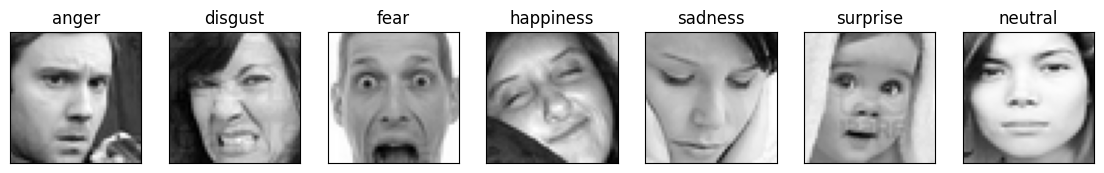

In [7]:
fig = plt.figure(1,(14,14))
k = 0
for label in sorted(df.emotion.unique()):
    px = df[df.emotion == label].pixels.iloc[k]
    px = np.array(px.split()).reshape(48,48,1).astype('float32')
    k += 1
    ax = plt.subplot(7,7,k)
    ax.imshow(px,cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_label_to_text[label])

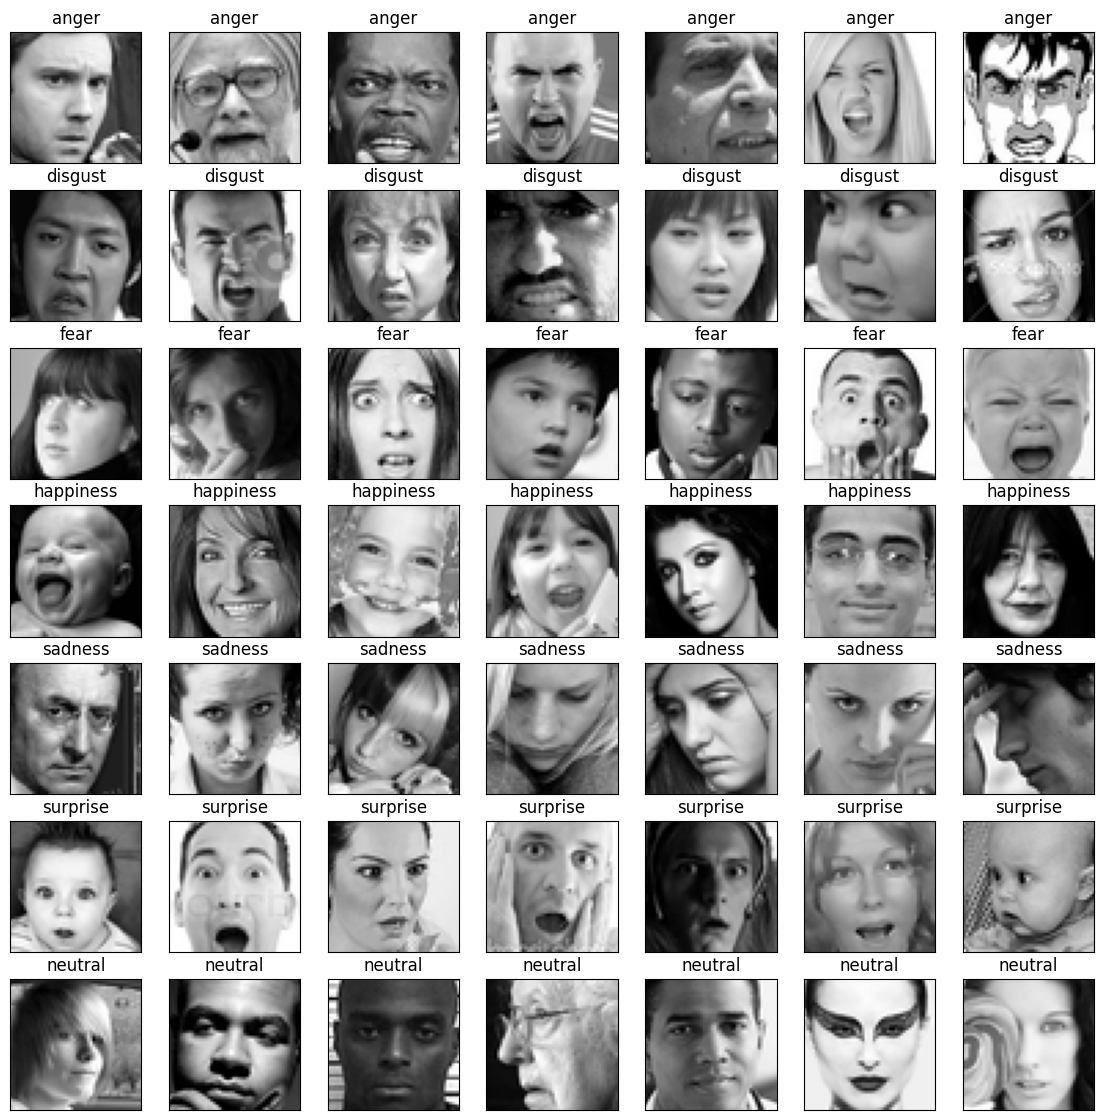

In [8]:
fig = plt.figure(1,(14,14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion == label].pixels.iloc[k]
        px = np.array(px.split()).reshape(48,48,1).astype('float32')
        k += 1
        ax = plt.subplot(7,7,k)
        ax.imshow(px,cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])


In [9]:
intrested_label = [3,4,6]

In [10]:
df = df[df.emotion.isin(intrested_label)]

In [11]:
df.shape

(21264, 3)

In [12]:
img_array = df.pixels.apply(lambda x: np.array(x.split()).reshape(48,48).astype('float32'))

In [13]:
img_array = np.stack(img_array,axis=0)

In [14]:
img_array.shape

(21264, 48, 48)

In [15]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [16]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))


In [17]:
le_name_mapping

{np.int64(3): np.int64(0), np.int64(4): np.int64(1), np.int64(6): np.int64(2)}

In [18]:
#train test split

x_train,x_test,y_train,y_test = train_test_split(img_array,img_labels,
                                                 test_size=0.1,
                                                 random_state=42,
                                                 shuffle=True,
                                                 stratify=img_labels)

In [19]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((19137, 48, 48), (2127, 48, 48), (19137, 3), (2127, 3))

In [20]:
x_train = x_train.reshape(-1,48,48,1)

In [21]:
# IMG_WIDTH, IMG_HEIGHT = 48, 48
# IMG_DEPTH = 1
# NUM_CLASSES = len(emotion_label_to_text)

# print(f"IMG_WIDTH: {IMG_WIDTH}")
# print(f"IMG_HEIGHT: {IMG_HEIGHT}")
# print(f"IMG_DEPTH: {IMG_DEPTH}")
# print(f"NUM_CLASSES: {NUM_CLASSES}")


IMG_WIDTH, IMG_HEIGHT = x_train.shape[1], x_train.shape[2]
IMG_DEPTH = x_train.shape[3]
NUM_CLASSES = y_train.shape[1]

print(f"IMG_WIDTH: {IMG_WIDTH}")
print(f"IMG_HEIGHT: {IMG_HEIGHT}")
print(f"IMG_DEPTH: {IMG_DEPTH}")
print(f"NUM_CLASSES: {NUM_CLASSES}")



IMG_WIDTH: 48
IMG_HEIGHT: 48
IMG_DEPTH: 1
NUM_CLASSES: 3


In [22]:

def build_net(optim):
    net = Sequential(name="DCNN")
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5, 5),
            input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH),
            padding="same",
            activation="elu",
            kernel_initializer="he_normal",
            name="Conv1"
        )
    )
    net.add(BatchNormalization(name="batch_normalisation_1"))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5, 5),
            padding="same",
            activation="elu",
            kernel_initializer="he_normal",
            name="Conv2"
        )
    )
    net.add(BatchNormalization(name="batch_normalisation_2"))
    net.add(
        MaxPooling2D(
            pool_size=(2, 2),
            name="pool1"
        )
    )
    net.add(Dropout(0.4, name="dropout1"))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            padding="same",
            activation="relu",
            kernel_initializer="he_normal",
            name="Conv3"
        )
    )
    net.add(BatchNormalization(name="batch_normalisation_3"))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            padding="same",
            activation="relu",
            kernel_initializer="he_normal",
            name="Conv4"
        )
    )
    net.add(BatchNormalization(name="batch_normalisation_4"))
    net.add(
        MaxPooling2D(
            pool_size=(2, 2),
            name="pool2"
        )
    )
    net.add(Dropout(0.4, name="dropout2"))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3, 3),
            padding="same",
            activation="relu",
            kernel_initializer="he_normal",
            name="Conv5"
        )
    )
    net.add(BatchNormalization(name="batch_normalisation_5"))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3, 3),
            padding="same",
            activation="relu",
            kernel_initializer="he_normal",
            name="Conv6"
        )
    )
    net.add(BatchNormalization(name="batch_normalisation_6"))
    net.add(
        MaxPooling2D(
            pool_size=(2, 2),
            name="pool3"
        )
    )
    net.add(Dropout(0.4, name="dropout3"))
    net.add(Flatten(name="flatten"))
    net.add(
        Dense(
            128,
            activation="relu",
            kernel_initializer="he_normal",
            name="dense1"
        )
    )
    net.add(BatchNormalization(name="batch_normalisation_7"))
    net.add(
        Dropout(0.6, name="dropout4")
    )
    net.add(
        Dense(
            NUM_CLASSES,
            activation="softmax",
            name="out_layer"
        )
    )

    net.compile(optimizer=optim, loss="categorical_crossentropy", metrics=["accuracy"])
    net.summary()

    return net


In [23]:
#----> ye code sir ka hai
# def build_net(optim):
#     net = Sequential(name = "DCNN")
#     net.add(
#         Conv2D(
#             filters = 64,
#             kernel_size = (5,5),
#             input_shape = (img_width, img_height, img_depth),
#             padding = "same",
#             activation = "elu",
#             kernel_initializer = "he_normal",
#             name = "conv2d_1"
#         )
#     )
#     ##bN is used after dense or before convo layer
#     net.add(BatchNormalization(
#         name = "batch_normalization_1"))
#     net.add(
#         Conv2D(
#             filters = 64 ,
#             kernel_size = (5,5),
#             activation = "elu",
#             padding = "same",
#             kernel_initializer = "he_normal",
#             name = "conv2d_2"
#         )
#     )
#     net.add(BatchNormalization(
#         name = "batch_normalization_2"))
#     net.add(
#         MaxPooling2D(
#             pool_size = (2,2),
#             name = "max_pooling2d_1"
#         )
#     )
#     net.add(Dropout(0.4,name = "droput_1"))
#     net.add(
#         Conv2D(
#             filters = 128 ,
#             kernel_size = (3,3),
#             activation = "elu",
#             padding = "same",
#             kernel_initializer = "he_normal",
#             name = "conv2d_3"
#         )
#     )
#     net.add(BatchNormalization(
#         name = "batch_normalization_3"))
#     net.add(
#         Conv2D(
#             filters = 128 ,
#             kernel_size = (3,3),
#             activation = "elu",
#             padding = "same",
#             kernel_initializer = "he_normal",
#             name = "conv2d_4"
#         )
#     )
#     net.add(BatchNormalization(
#         name = "batch_normalization_4"))
#     net.add(
#         MaxPooling2D(
#             pool_size = (2,2),
#             name = "max_pooling2d_2"
#         )
#     )
#     net.add(Dropout(0.4,name = "droput_2"))

#     net.add(
#         Conv2D(
#             filters = 256 ,
#             kernel_size = (3,3),
#             activation = "elu",
#             padding = "same",
#             kernel_initializer = "he_normal",
#             name = "conv2d_5"
#         )
#     )
#     net.add(BatchNormalization(
#         name = "batch_normalization_5"))
#     net.add(
#         Conv2D(
#             filters = 256 ,
#             kernel_size = (3,3),
#             activation = "elu",
#             padding = "same",
#             kernel_initializer = "he_normal",
#             name = "conv2d_6"
#         )
#     )
#     net.add(BatchNormalization(
#         name = "batch_normalization_6"))
#     net.add(
#         MaxPooling2D(
#             pool_size = (2,2),
#             name = "max_pooling2d_3"
#         )
#     )
#     net.add(Dropout(0.5,name = "droput_3"))

#     net.add(Flatten(name = "flatten"))
#     net.add(
#         Dense(
#             128,
#             activation = "elu",
#             kernel_initializer = "he_normal",
#             name = "dense_1"
#         )
#     )
#     net.add(BatchNormalization(
#         name = "batch_normalization_7"))
#     net.add(Dropout(0.6,name = "droput_4"))
#     net.add(
#         Dense(num_classes,
#             activation = "softmax",
#             name = "out_layer"
#         )
#     )

#     net.compile(
#         loss = "categorical_crossentropy",
#         optimizer = optim,
#         metrics = ["accuracy"]
#     )
#     net.summary()
#     return net

In [24]:
early_stoping = EarlyStopping(
    monitor='val_accuracy',
    min_delta = 0.00005,
    patience = 11,
    verbose = 1,
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor = 0.5,
    patience = 5,
    verbose = 1,
    min_lr = 1e-7

)
call_backs = [early_stoping, reduce_lr]

In [25]:


# Train the model
# Define the optimizer
optim = optimizers.Adam(learning_rate=0.001)

# Build the model
net = build_net(optim)

# Data augmentation (optional but recommended for image data)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator on the training data
datagen.fit(x_train)

# Train the model
history = net.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=50,  # Adjust the number of epochs as needed
    validation_data=(x_test, y_test),
    callbacks=call_backs,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalisation_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalisation_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalisation_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalisation_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalisation_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv6 (Conv2D)                  │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalisation_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalisation_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,075 (9.14 MB)

 Trainable params: 2,393,027 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 0.3889 - loss: 1.5039 - val_accuracy: 0.5496 - val_loss: 0.9662 - learning_rate: 0.0010
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.5211 - loss: 1.0291 - val_accuracy: 0.6102 - val_loss: 0.8625 - learning_rate: 0.0010
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.5853 - loss: 0.8890 - val_accuracy: 0.6347 - val_loss: 0.7966 - learning_rate: 0.0010
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6325 - loss: 0.7856 - val_accuracy: 0.6949 - val_loss: 0.6972 - learning_rate: 0.0010
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6589 - loss: 0.7361 - val_accuracy: 0.6643 - val_loss: 0.7129 - learning_rate: 0.0010
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6914 - loss: 0.6893 - val_accuracy: 0.7000 - val_loss: 0.6677 - learning_rate: 0.0010
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.6973 - loss: 0.6664

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src

300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8393 - loss: 0.3890 - val_accuracy: 0.8129 - val_loss: 0.4768 - learning_rate: 1.2500e-04
Epoch 45/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8449 - loss: 0.3828
Epoch 45: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8449 - loss: 0.3828 - val_accuracy: 0.8035 - val_loss: 0.4906 - learning_rate: 1.2500e-04
Epoch 46/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8484 - loss: 0.3805 - val_accuracy: 0.8185 - val_loss: 0.4702 - learning_rate: 6.2500e-05
Epoch 47/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8430 - loss: 0.3834 - val_accuracy: 0.8148 - val_loss: 0.4738 - learning_rate: 6.2500e-05
Epoch 48/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8476 - loss: 0.3846 - val_accuracy: 0.8143 - val_loss: 0.4752 - learning_rate: 6.2500e-05
Epoch 49/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy

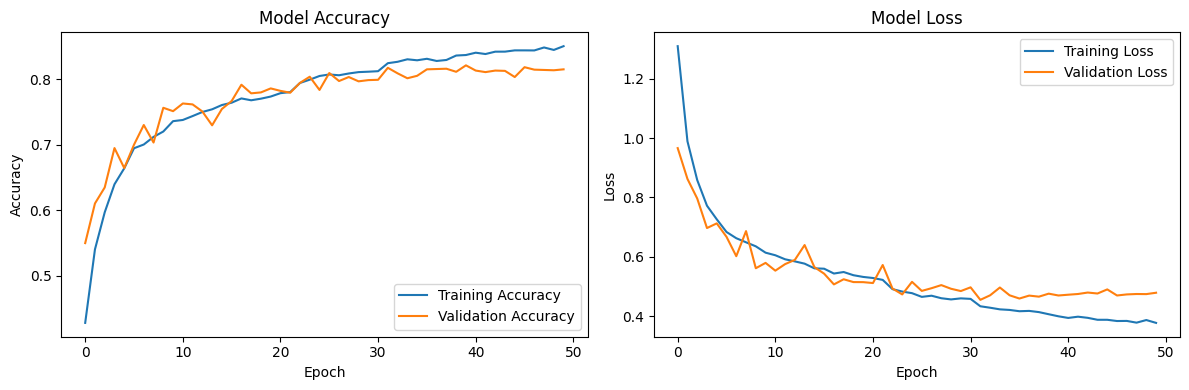

In [26]:
# prompt: plot model accuarcy and loss graph

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
The predicted emotion is: neutral


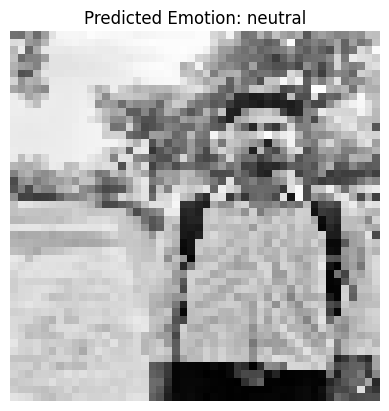

In [28]:
# prompt: tesing a fcial experrison image of my, photo is sotred at /content/sample_data/test.jpeg

# Load and preprocess the test image
test_image_path = '/content/sample_data/IMG_0007.jpg'
img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE) # Load as grayscale
img = cv2.resize(img, (48, 48)) # Resize to match the model's input size
img = np.array(img).astype('float32') # Convert to numpy array and float32
img = img / 255.0 # Normalize the image
img = np.expand_dims(img, axis=0) # Add batch dimension
img = np.expand_dims(img, axis=-1) # Add channel dimension

# Make a prediction
prediction = net.predict(img)

# Get the predicted emotion
predicted_class_index = np.argmax(prediction)
predicted_emotion_label = le.inverse_transform([predicted_class_index])[0]
predicted_emotion_text = emotion_label_to_text[predicted_emotion_label]

print(f"The predicted emotion is: {predicted_emotion_text}")

# Optional: Display the image and the prediction
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Predicted Emotion: {predicted_emotion_text}")
plt.axis('off')
plt.show()

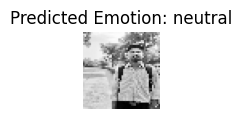

In [31]:
# prompt: the above img is too large make it small

# Optional: Display the image and the prediction
plt.figure(figsize=(1, 1)) # Adjust figure size for smaller image
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Predicted Emotion: {predicted_emotion_text}")
plt.axis('off')
plt.show()
